# curated Y chromosome assemblies from Arang Rhie (NIH)

Perhaps you could look into these curated Ys here to see if it helps?  
https://s3-us-west-2.amazonaws.com/human-pangenomics/index.html?prefix=T2T/scratch/chrY/  
hgsvc = 29 verkko assemblies  
v2 = 106 curated HPRC verkko assemblies

# Overall non-B Across All Curated Y's - HPRC + HGSVC

Counts per dataset in prop_df:
 Dataset
HPRC     742
HGSVC    203
Name: count, dtype: int64


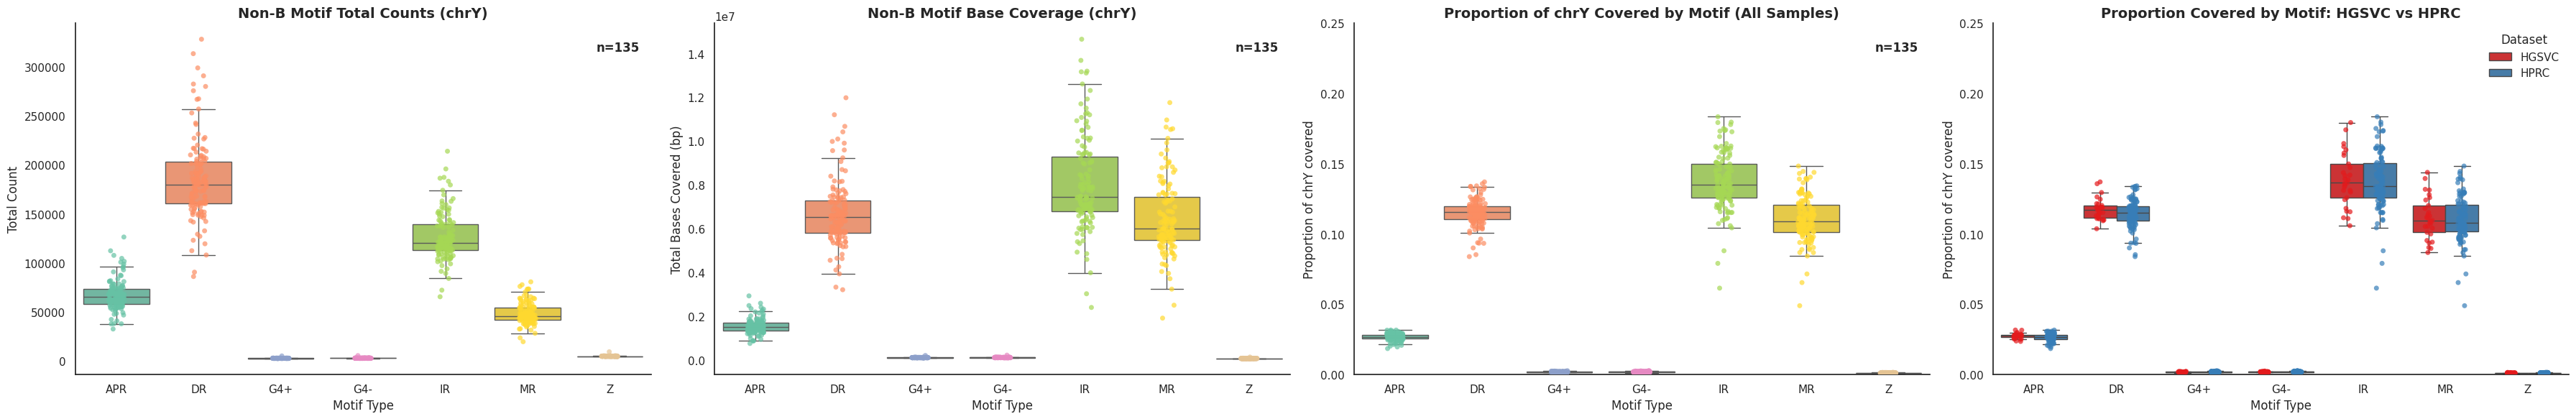

In [1]:
#!/usr/bin/env python3
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Configure your input files here ===
csv_paths = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hgsvc_verkko_nBMST_summary.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hprc_verkko_nBMST_summary.csv",
]

# Add your two G4 CSVs here (they look like: Sample,POS,STR,L,Q,SEQUENCE)
g4_csv_paths = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hgsvc_verkko.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hprc_verkko.csv",
]

# NOTE: this file contains lengths for BOTH datasets (that’s fine)
lengths_tsv = "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/chrY_lengths_combined_hgsvc_hprc.tsv"

# Column schema for motif summary CSVs
COLS = ["Sample_Haplotype_Chromosome", "Motif Type", "Total Count", "Total Bases Covered"]

def infer_dataset(path: str) -> str:
    """
    Infer dataset from the *filename* only, not the directory.
    Accepts 'hgsvc' or 'hprc' (case-insensitive) as tokens separated by
    start/end/underscore/dash/dot.
    """
    name = Path(str(path)).name.lower()
    if re.search(r'(^|[_\-])hgsvc([_\-]|\.|$)', name):
        return "HGSVC"
    if re.search(r'(^|[_\-])hprc([_\-]|\.|$)', name):
        return "HPRC"
    return "Unknown"

def read_flexible(path):
    """Reads a CSV that may or may not have a header, and returns motif summary columns + Dataset."""
    try:
        df = pd.read_csv(path)
        if not set(COLS).issubset(df.columns):
            df = pd.read_csv(path, header=None, names=COLS)
    except pd.errors.ParserError:
        df = pd.read_csv(path, header=None, names=COLS)
    df["Dataset"] = infer_dataset(path)
    return df

def read_g4_calls(paths):
    """
    Read G4 call CSVs with columns: Sample,POS,STR,L,Q,SEQUENCE
    Create per-row 'Motif Type' as 'G4+' for STR=='+', 'G4-' for STR=='-'.
    Return aggregated per Sample & Motif Type with columns matching COLS plus Dataset.
    """
    frames = []
    use_cols = ["Sample", "POS", "STR", "L", "Q", "SEQUENCE"]

    for p in paths:
        try:
            df = pd.read_csv(p)
            if not set(use_cols).issubset(df.columns):
                df = pd.read_csv(p, header=None, names=use_cols)
        except pd.errors.ParserError:
            df = pd.read_csv(p, header=None, names=use_cols)

        df["Sample"] = df["Sample"].astype(str).str.split("_chr").str[0]
        df["Motif Type"] = df["STR"].map({"+": "G4+", "-": "G4-"}).fillna("G4?")
        df["L"] = pd.to_numeric(df["L"], errors="coerce")
        seq_len = df["SEQUENCE"].fillna("").map(len)
        df["BaseLen"] = df["L"].fillna(seq_len)
        df["Dataset"] = infer_dataset(p)

        agg = (df.groupby(["Sample", "Motif Type", "Dataset"], as_index=False)
                 .agg(**{
                     "Total Count": ("Motif Type", "count"),
                     "Total Bases Covered": ("BaseLen", "sum"),
                 }))
        frames.append(agg)

    if not frames:
        return pd.DataFrame(columns=["Sample", "Motif Type", "Dataset", "Total Count", "Total Bases Covered"])

    g4_agg = pd.concat(frames, ignore_index=True)
    g4_agg = (g4_agg.groupby(["Sample", "Motif Type", "Dataset"], as_index=False)
                    .agg({"Total Count": "sum", "Total Bases Covered": "sum"}))
    return g4_agg

# === Load & combine motif summaries ===
frames = [read_flexible(p) for p in csv_paths]
df = pd.concat(frames, ignore_index=True)

# Ensure numeric types
df["Total Count"] = pd.to_numeric(df["Total Count"], errors="coerce")
df["Total Bases Covered"] = pd.to_numeric(df["Total Bases Covered"], errors="coerce")

# Normalize sample ID from summary files
df["Sample"] = df["Sample_Haplotype_Chromosome"].astype(str).str.split("_chr").str[0]

# Aggregate per sample/motif/dataset
agg_df_core = (
    df.groupby(["Sample", "Motif Type", "Dataset"], as_index=False)
      .agg({"Total Count": "sum", "Total Bases Covered": "sum"})
      .dropna(subset=["Total Count", "Total Bases Covered"])
)

# === G4 +/- aggregation ===
g4_agg = read_g4_calls(g4_csv_paths)[["Sample", "Motif Type", "Dataset", "Total Count", "Total Bases Covered"]]

# Combine core + G4
agg_df = pd.concat([agg_df_core, g4_agg], ignore_index=True)

# === chrY lengths (has both datasets; we merge by Sample only) ===
len_df = pd.read_csv(lengths_tsv, sep="\t")
len_df["Sample"] = len_df["Sample"].astype(str).str.split("_chr").str[0]
len_df = len_df.groupby("Sample", as_index=False).agg(Length=("Length", "max"))

# Merge to compute proportions (keeps Dataset from agg_df)
prop_df = agg_df.merge(len_df, on="Sample", how="inner")
prop_df = prop_df[prop_df["Length"] > 0].copy()
prop_df["Proportion Covered"] = prop_df["Total Bases Covered"] / prop_df["Length"]

# Simple sanity check — make sure we have both datasets
print("Counts per dataset in prop_df:\n", prop_df["Dataset"].value_counts(dropna=False))

# === Counts for n annotations ===
n_samples = agg_df["Sample"].nunique()
n_samples_prop = prop_df["Sample"].nunique()

# Order motif types
motif_order = sorted(agg_df["Motif Type"].dropna().unique().tolist())
agg_df["Motif Type"] = pd.Categorical(agg_df["Motif Type"], categories=motif_order, ordered=True)
prop_df["Motif Type"] = pd.Categorical(prop_df["Motif Type"], categories=motif_order, ordered=True)

# === Style (no gridlines) ===
sns.set_theme(style="white")
palette = sns.color_palette("Set2", n_colors=len(motif_order))

# === Build 4 panels ===
fig, axes = plt.subplots(1, 4, figsize=(36, 6), sharex=False)

def box_strip(ax, data, y_col, y_label, title, n_label):
    sns.boxplot(
        data=data, x="Motif Type", y=y_col, hue="Motif Type",
        palette=palette, showfliers=False, legend=False, ax=ax
    )
    sns.stripplot(
        data=data, x="Motif Type", y=y_col, hue="Motif Type",
        palette=palette, alpha=0.7, jitter=True, dodge=False, legend=False, ax=ax
    )
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Motif Type")
    ax.set_ylabel(y_label)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.98, 0.95, f"n={n_label}", transform=ax.transAxes,
            ha="right", va="top", fontsize=12, fontweight="bold")

# Panel 1: Total Count
box_strip(axes[0], agg_df, "Total Count", "Total Count", "Non-B Motif Total Counts (chrY)", n_samples)

# Panel 2: Total Bases Covered
box_strip(axes[1], agg_df, "Total Bases Covered", "Total Bases Covered (bp)", "Non-B Motif Base Coverage (chrY)", n_samples)

# Panel 3: Proportion of chrY covered (all samples)
sns.boxplot(
    data=prop_df, x="Motif Type", y="Proportion Covered", hue="Motif Type",
    palette=palette, showfliers=False, legend=False, ax=axes[2]
)
sns.stripplot(
    data=prop_df, x="Motif Type", y="Proportion Covered", hue="Motif Type",
    palette=palette, alpha=0.7, jitter=True, dodge=False, legend=False, ax=axes[2]
)
axes[2].set_title("Proportion of chrY Covered by Motif (All Samples)", fontsize=14, weight="bold")
axes[2].set_xlabel("Motif Type")
axes[2].set_ylabel("Proportion of chrY covered")
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].text(0.98, 0.95, f"n={n_samples_prop}", transform=axes[2].transAxes,
             ha="right", va="top", fontsize=12, fontweight="bold")
axes[2].set_ylim(0, 0.25)

# Panel 4: Proportion of chrY covered, HGSVC vs HPRC comparison
datasets_present = list(pd.unique(prop_df["Dataset"]))
# Keep a nice fixed order if both present
if set(datasets_present) >= {"HGSVC", "HPRC"}:
    hue_order = ["HGSVC", "HPRC"]
else:
    hue_order = datasets_present  # whatever exists (1 or more)
dataset_palette = sns.color_palette("Set1", n_colors=len(hue_order))

sns.boxplot(
    data=prop_df, x="Motif Type", y="Proportion Covered", hue="Dataset",
    hue_order=hue_order, palette=dataset_palette, showfliers=False, dodge=True, ax=axes[3]
)
sns.stripplot(
    data=prop_df, x="Motif Type", y="Proportion Covered", hue="Dataset",
    hue_order=hue_order, palette=dataset_palette, alpha=0.7, jitter=True, dodge=True, ax=axes[3]
)
handles, labels = axes[3].get_legend_handles_labels()
# De-duplicate legend entries (boxplot+stripplot)
seen = {}
unique_handles, unique_labels = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen[l] = True
        unique_handles.append(h)
        unique_labels.append(l)
axes[3].legend(unique_handles, unique_labels, title="Dataset", frameon=False, loc="upper right")

axes[3].set_title("Proportion Covered by Motif: HGSVC vs HPRC", fontsize=14, weight="bold")
axes[3].set_xlabel("Motif Type")
axes[3].set_ylabel("Proportion of chrY covered")
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)
axes[3].set_ylim(0, 0.25)

plt.tight_layout()
plt.show()

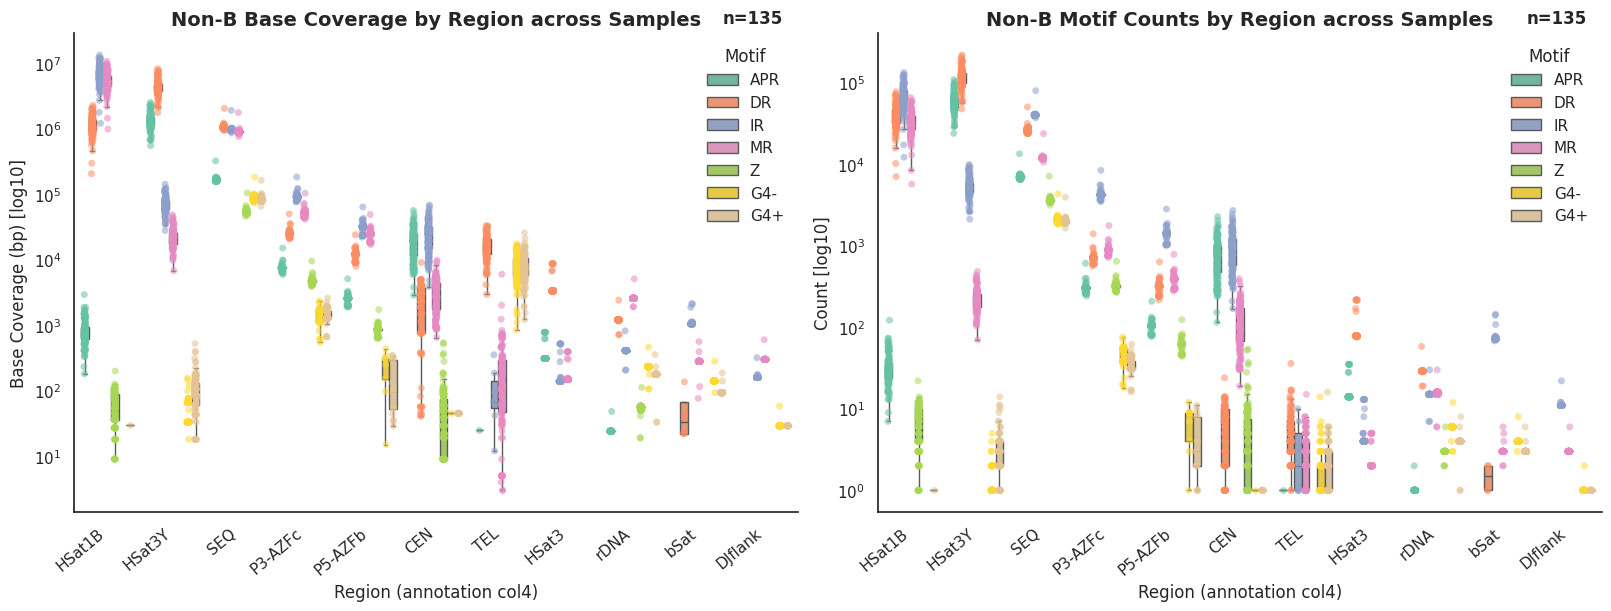

In [1]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# ==== CONFIG ====
CSV_PATHS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hgsvc_verkko_nBMST_annotations_collapsed_summary.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hprc_verkko_nBMST_annotations_collapsed_summary.csv",
]
G4_ANNOTATED_CSVS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hgsvc_verkko_annotated.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hprc_verkko_annotated.csv"
]
REGION_LENGTH_CSVS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/chrY_region_lengths_hgsvc_filtered.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/chrY_region_lengths_hprc_filtered.csv",
]

MOTIF_SET = ["APR","DR","IR","MR","Z","G4-","G4+"]
USE_LOG10 = True
SHOW_COVERAGE_PANEL = True
SHOW_COUNT_PANEL = True
EXCLUDE_COLOR_BLOCKS = True

COLOR_REGEX = re.compile(r"^(yellow|blue|red|teal|green|gray|purple|orange|pink)\d*[ab]?$", re.IGNORECASE)

# ---- Load & combine non-B summary CSVs ----
frames = []
for path in CSV_PATHS:
    frames.append(pd.read_csv(path))
nonb_df = pd.concat(frames, ignore_index=True)

need = {"Sample","Motif","Region","TotalCount","TotalBaseCoverageBP"}
if not need.issubset(nonb_df.columns):
    raise SystemExit(f"Non-B summary CSV must have columns: {need}. Found: {nonb_df.columns.tolist()}")

nonb_df = nonb_df.rename(columns={"TotalCount":"Count", "TotalBaseCoverageBP":"BaseCoverageBP"})
nonb_df["Sample"] = nonb_df["Sample"].astype(str).str.split("_chr").str[0]

# ---- Load & convert G4 annotated CSVs ----
g4_frames = []
for p in G4_ANNOTATED_CSVS:
    g4 = pd.read_csv(p)
    need_g4 = {"Sample","STR","Region","Count","OverlapBP"}
    if not need_g4.issubset(g4.columns):
        raise SystemExit(f"G4 annotated CSV must have columns {need_g4}. Found: {g4.columns.tolist()} in {p}")

    tmp = pd.DataFrame({
        "Sample": g4["Sample"].astype(str).str.split("_chr").str[0],
        "Motif": g4["STR"].map({"+":"G4+","-":"G4-"}).fillna("G4?"),
        "Region": g4["Region"].astype(str),
        "Count": pd.to_numeric(g4["Count"], errors="coerce").fillna(0),
        "BaseCoverageBP": pd.to_numeric(g4["OverlapBP"], errors="coerce").fillna(0),
    })
    tmp = (tmp.groupby(["Sample","Motif","Region"], as_index=False)
              .agg(Count=("Count","sum"), BaseCoverageBP=("BaseCoverageBP","sum")))
    tmp = tmp[tmp["Motif"].isin(["G4+","G4-"])]
    g4_frames.append(tmp)

g4_df = pd.concat(g4_frames, ignore_index=True) if g4_frames else pd.DataFrame(columns=["Sample","Motif","Region","Count","BaseCoverageBP"])

# ---- Combine non-B with G4 ----
df = pd.concat([nonb_df, g4_df], ignore_index=True)

# Filter regions
if EXCLUDE_COLOR_BLOCKS:
    df = df[~df["Region"].astype(str).str.match(COLOR_REGEX)]
df = df[df["Region"].astype(str) != "."]

# Keep motifs
if MOTIF_SET:
    df = df[df["Motif"].str.upper().isin([m.upper() for m in MOTIF_SET])].copy()
    df["Motif"] = pd.Categorical(df["Motif"], categories=MOTIF_SET, ordered=True)

# n_samples
n_samples = df["Sample"].nunique()

# Region order
region_order = (
    df.groupby("Region")["BaseCoverageBP"]
      .mean()
      .sort_values(ascending=False)
      .index.tolist()
)
df["Region"] = pd.Categorical(df["Region"], categories=region_order, ordered=True)

# ---- Plotting helpers ----
sns.set_theme(style="white")
palette = sns.color_palette("Set2", n_colors=len(MOTIF_SET))

def box_strip(ax, data, y_col, y_label, title, use_log=True, ylim=None):
    sns.boxplot(
        data=data, x="Region", y=y_col, hue="Motif",
        palette=palette, showfliers=False, dodge=True, ax=ax
    )
    sns.stripplot(
        data=data, x="Region", y=y_col, hue="Motif",
        palette=palette, dodge=True, alpha=0.55, ax=ax, legend=False
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:len(MOTIF_SET)], labels[:len(MOTIF_SET)],
              title="Motif", loc="upper right", frameon=False)
    ax.set_xlabel("Region (annotation col4)")
    ax.set_ylabel(y_label + (" [log10]" if (use_log and USE_LOG10) else ""))
    ax.set_title(title, fontsize=14, weight="bold")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.text(0.98, 1.05, f"n={n_samples}", transform=ax.transAxes,
            ha="right", va="top", fontsize=12, fontweight="bold")
    plt.setp(ax.get_xticklabels(), rotation=40, ha="right")
    if use_log and USE_LOG10:
        ax.set_yscale("log")
    if ylim is not None:
        ax.set_ylim(*ylim)

# ---- Plot only the first two panels ----
n_panels = int(SHOW_COVERAGE_PANEL) + int(SHOW_COUNT_PANEL)
fig, axes = plt.subplots(1, n_panels, figsize=(8*n_panels, 6), constrained_layout=True)
if n_panels == 1:
    axes = [axes]
ax_i = 0

if SHOW_COVERAGE_PANEL:
    box_strip(axes[ax_i], df, "BaseCoverageBP", "Base Coverage (bp)",
              "Non-B Base Coverage by Region across Samples", use_log=True)
    ax_i += 1

if SHOW_COUNT_PANEL:
    box_strip(axes[ax_i], df, "Count", "Count",
              "Non-B Motif Counts by Region across Samples", use_log=True)
    ax_i += 1

plt.show()

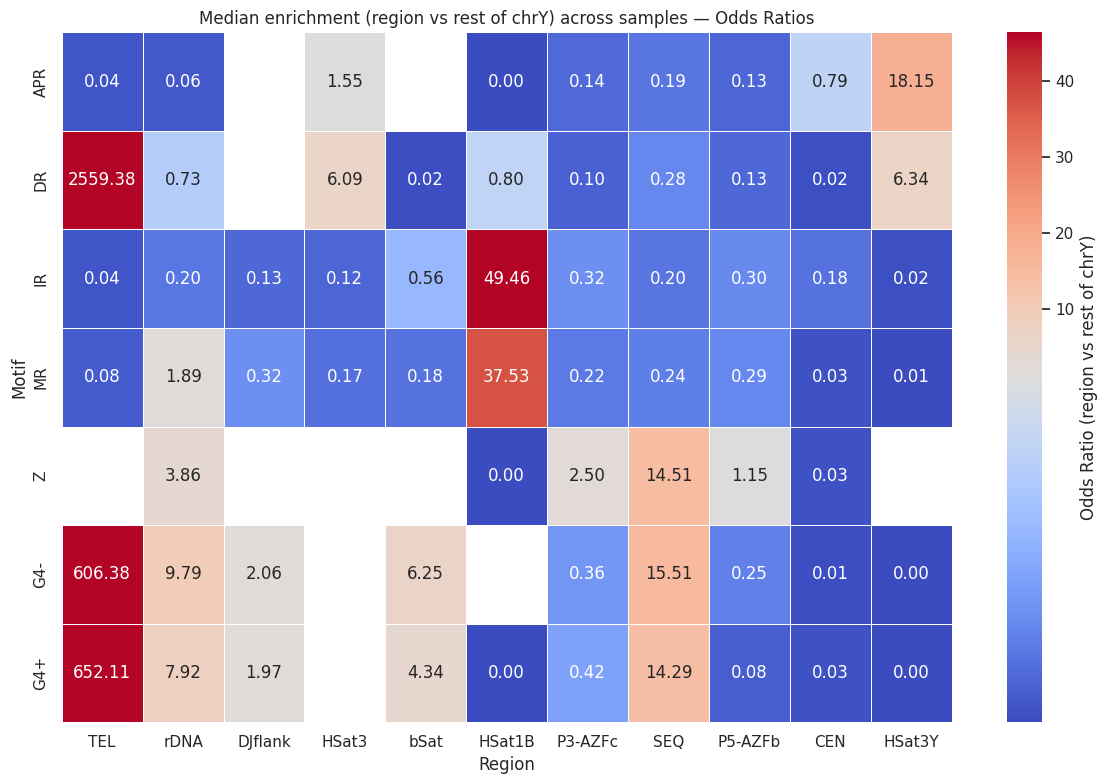

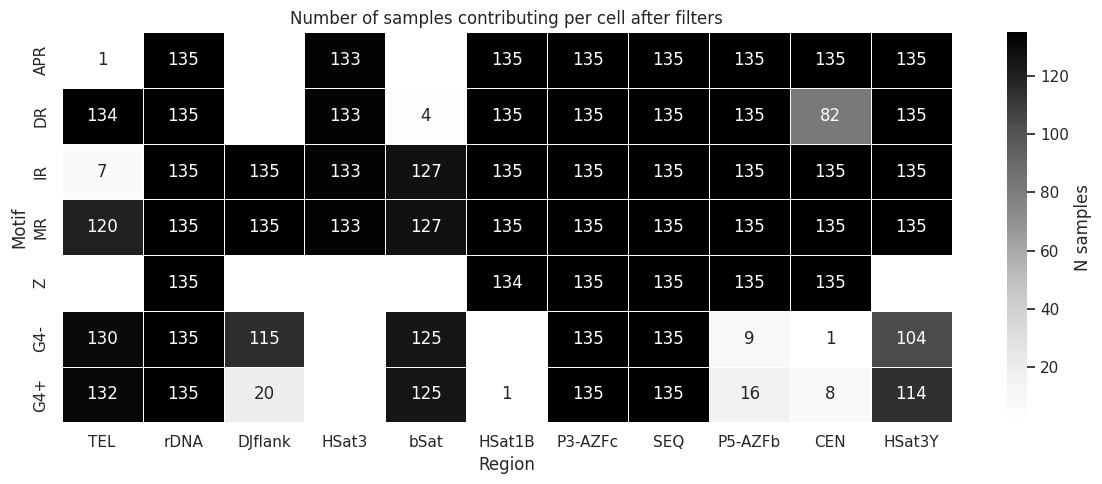

In [2]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ================== CONFIG ==================
# Region-length CSVs (must have: Sample, Region, RegionLengthBP, SampleTotalChrYLengthBP)
REGION_LENGTH_CSVS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/chrY_region_lengths_hgsvc_filtered.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/chrY_region_lengths_hprc_filtered.csv",
]

# Non-B summary CSVs (must have: Sample, Motif, Region, TotalCount, TotalBaseCoverageBP)
NONB_SUMMARY_CSVS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hgsvc_verkko_nBMST_annotations_collapsed_summary.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hprc_verkko_nBMST_annotations_collapsed_summary.csv",
]

# G4 annotated CSVs (from your annotator; must have: Sample, POS, STR, L, Q, Region, Count, OverlapBP)
G4_ANNOTATED_CSVS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hgsvc_verkko_annotated.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hprc_verkko_annotated.csv"
]

# Motifs to include (row order on the heatmap)
MOTIF_SET = ["APR","DR","IR","MR","Z"]  # we'll auto-append G4± if provided

# Filters to “only use what’s present” per sample:
MIN_REGION_BP = 1                        # require region length > 0
REQUIRE_OUTSIDE_NONZERO = True           # require (L - region_bp) > 0
REQUIRE_TOTAL_MOTIF_NONZERO = True       # require total motif bp on chrY > 0 for that sample+motif
REQUIRE_MOTIF_PRESENT_IN_REGION = True   # skip if motif bp in region == 0

# Plot controls
ANNOTATE_ALL_CELLS = True     # label every cell with its median OR
DECIMALS = 2                  # annotation precision
SHOW_N_HEATMAP = True         # show second heatmap of N contributing samples
FIGSIZE_MAIN = (12, 8)
FIGSIZE_N = (12, 5)
# ============================================

def load_region_lengths(paths):
    frames = []
    for p in paths:
        df = pd.read_csv(p)
        need = {"Sample","Region","RegionLengthBP","SampleTotalChrYLengthBP"}
        if not need.issubset(df.columns):
            raise SystemExit(f"[ERROR] {p} missing {need}. Got {df.columns.tolist()}")
        frames.append(df[list(need)])
    rl = pd.concat(frames, ignore_index=True)
    # Sum region length per Sample×Region; take max total length per sample
    rl = (rl.groupby(["Sample","Region"], as_index=False)
            .agg(RegionLengthBP=("RegionLengthBP","sum"),
                 SampleTotalChrYLengthBP=("SampleTotalChrYLengthBP","max")))
    # Keep valid totals
    rl = rl.dropna(subset=["SampleTotalChrYLengthBP"])
    rl = rl[rl["SampleTotalChrYLengthBP"] > 0]
    return rl

def load_nonb(paths, motifs):
    frames = []
    for p in paths:
        df = pd.read_csv(p)
        need = {"Sample","Motif","Region","TotalCount","TotalBaseCoverageBP"}
        if not need.issubset(df.columns):
            raise SystemExit(f"[ERROR] {p} missing {need}. Got {df.columns.tolist()}")
        frames.append(df[list(need)])
    nb = pd.concat(frames, ignore_index=True)
    nb["Motif"] = nb["Motif"].str.upper()
    nb = nb[nb["Motif"].isin([m.upper() for m in motifs])].copy()
    # Collapse duplicates across inputs
    nb = (nb.groupby(["Sample","Motif","Region"], as_index=False)
            .agg(TotalBaseCoverageBP=("TotalBaseCoverageBP","sum"),
                 TotalCount=("TotalCount","sum")))
    return nb

def load_g4(paths):
    """
    Convert G4 annotated rows to the same schema as NONB (Sample, Motif, Region, TotalCount, TotalBaseCoverageBP).
    - Collapse Sample to base (before '_chr') so it aligns with region-length/non-B summaries.
    - Motif = 'G4+' (STR=='+') or 'G4-' (STR=='-').
    - Use OverlapBP as TotalBaseCoverageBP; sum Count as TotalCount.
    """
    frames = []
    need = {"Sample","STR","Region","Count","OverlapBP"}
    for p in paths:
        g = pd.read_csv(p)
        if not need.issubset(g.columns):
            raise SystemExit(f"[ERROR] {p} missing {need}. Got {g.columns.tolist()}")
        tmp = pd.DataFrame({
            "Sample": g["Sample"].astype(str).str.split("_chr").str[0],  # base sample
            "Motif": g["STR"].map({"+": "G4+", "-": "G4-"}).astype(str),
            "Region": g["Region"].astype(str),
            "TotalCount": pd.to_numeric(g["Count"], errors="coerce").fillna(0),
            "TotalBaseCoverageBP": pd.to_numeric(g["OverlapBP"], errors="coerce").fillna(0),
        })
        # Aggregate to Sample×Motif×Region
        tmp = (tmp.groupby(["Sample","Motif","Region"], as_index=False)
                  .agg(TotalBaseCoverageBP=("TotalBaseCoverageBP","sum"),
                       TotalCount=("TotalCount","sum")))
        frames.append(tmp)
    if not frames:
        return pd.DataFrame(columns=["Sample","Motif","Region","TotalCount","TotalBaseCoverageBP"])
    return pd.concat(frames, ignore_index=True)

def fisher_or(a, b, c, d):
    """Fisher OR with Haldane–Anscombe correction if any cell is zero."""
    a, b, c, d = map(float, (a, b, c, d))
    if min(a,b,c,d) == 0:
        a += 0.5; b += 0.5; c += 0.5; d += 0.5
    if (a+b) == 0 or (c+d) == 0:
        return np.nan
    try:
        OR, _ = fisher_exact([[a, c], [b, d]], alternative="greater")
    except Exception:
        OR = np.nan
    return OR

def compute_or_per_sample(rl, nb):
    # Inner join ensures: only regions that EXIST for that sample are considered
    merged = nb.merge(rl, on=["Sample","Region"], how="inner")

    # Background: total motif bp per sample×motif
    tot = (merged.groupby(["Sample","Motif"], as_index=False)["TotalBaseCoverageBP"]
                 .sum().rename(columns={"TotalBaseCoverageBP":"TotalMotifBP_chrY"}))
    merged = merged.merge(tot, on=["Sample","Motif"], how="left")

    records = []
    for (s, m, r), g in merged.groupby(["Sample","Motif","Region"]):
        row = g.iloc[0]
        a = int(row["TotalBaseCoverageBP"])            # motif bp IN region
        region_bp = int(row["RegionLengthBP"])
        L = int(row["SampleTotalChrYLengthBP"])        # total chrY bp for this sample
        total_motif = int(row["TotalMotifBP_chrY"])    # total motif bp on chrY for this sample+motif

        # --- per-sample presence filters ---
        if region_bp < MIN_REGION_BP:
            continue
        if REQUIRE_OUTSIDE_NONZERO and (L - region_bp) <= 0:
            continue
        if REQUIRE_TOTAL_MOTIF_NONZERO and total_motif <= 0:
            continue
        if REQUIRE_MOTIF_PRESENT_IN_REGION and a <= 0:
            continue

        # Build 2x2 table (clamped)
        b = max(region_bp - a, 0)                      # non-motif bp IN region
        c = max(total_motif - a, 0)                    # motif bp OUTSIDE region
        d = max((L - region_bp) - c, 0)                # non-motif bp OUTSIDE region

        OR = fisher_or(a, b, c, d)
        records.append((s, m, r, OR))

    ors = pd.DataFrame(records, columns=["Sample","Motif","Region","OR"])
    return ors

def prepare_matrices(ors, motifs_order):
    # Median across samples per Motif×Region
    med = (ors.groupby(["Motif","Region"], as_index=False)
               .agg(MedianOR=("OR","median"),
                    N=("OR", lambda x: x.notna().sum())))

    mat = med.pivot(index="Motif", columns="Region", values="MedianOR")
    mat = mat.reindex(motifs_order)  # enforce row order

    n_mat = med.pivot(index="Motif", columns="Region", values="N")
    n_mat = n_mat.reindex(motifs_order)

    # Drop all-NaN columns (no sample contributed after filters)
    keep_cols = mat.columns[~mat.isna().all()]
    mat = mat[keep_cols]
    n_mat = n_mat[keep_cols]

    return mat, n_mat

def plot_heatmap_or_with_labels(mat, title, annotate=True, decimals=2, figsize=(16,7)):
    # Drop empty rows/cols
    mat = mat.dropna(axis=0, how="all").dropna(axis=1, how="all")
    if mat.size == 0:
        raise SystemExit("Nothing to plot after filtering (all NaN).")

    plot_mat = mat.copy()  # raw ORs

    # Robust limits (clip extreme outliers)
    vals = plot_mat.values[np.isfinite(plot_mat.values)]
    if vals.size == 0:
        raise SystemExit("No finite OR values to plot.")
    vmax = np.nanpercentile(vals, 95)
    vmin = np.nanpercentile(vals, 5)

    # Ensure we span below and above 1 so center at OR=1 is meaningful
    if vmax <= 1:
        vmax = 1.01
    if vmin >= 1:
        vmin = 0.99

    norm = TwoSlopeNorm(vmin=vmin, vcenter=1.0, vmax=vmax)

    # Build annotation matrix (strings) for labels
    annot_mat = None
    if annotate:
        annot_mat = plot_mat.map(lambda x: f"{x:.{decimals}f}" if pd.notna(x) else "")

    sns.set_theme(style="white")
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        plot_mat,
        cmap="coolwarm",
        norm=norm,                # center at OR=1
        linewidths=0.4, linecolor="white",
        cbar_kws={"label": "Odds Ratio (region vs rest of chrY)"},
        annot=annot_mat,
        fmt=""  # strings already formatted
    )
    ax.set_xlabel("Region")
    ax.set_ylabel("Motif")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_n_heatmap(n_mat, title, figsize=(16,3)):
    # Drop empty
    n_mat = n_mat.dropna(axis=0, how="all").dropna(axis=1, how="all")
    if n_mat.size == 0:
        return
    sns.set_theme(style="white")
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        n_mat, cmap="Greys",
        annot=True, fmt=".0f",
        linewidths=0.4, linecolor="white",
        cbar_kws={"label": "N samples"}
    )
    ax.set_xlabel("Region")
    ax.set_ylabel("Motif")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def main():
    rl = load_region_lengths(REGION_LENGTH_CSVS)

    # Non-B
    nb_nonb = load_nonb(NONB_SUMMARY_CSVS, MOTIF_SET)

    # G4 (optional; will be empty if list is empty)
    g4_df = load_g4(G4_ANNOTATED_CSVS)

    # If G4 present, append rows and extend motif set (order: existing + G4-, G4+)
    if not g4_df.empty:
        nb = pd.concat([nb_nonb, g4_df], ignore_index=True)
        extra = [m for m in ["G4-","G4+"] if m not in MOTIF_SET]
        motifs_for_plot = MOTIF_SET + extra
    else:
        nb = nb_nonb
        motifs_for_plot = MOTIF_SET

    ors = compute_or_per_sample(rl, nb)

    # Build matrices
    mat, n_mat = prepare_matrices(ors, motifs_for_plot)

    # Sort columns by descending median OR to improve readability
    col_order = np.nanmedian(mat.values, axis=0)
    col_idx = np.argsort(col_order)[::-1]
    mat = mat.iloc[:, col_idx]
    n_mat = n_mat.iloc[:, col_idx]

    # Plot raw OR heatmap (centered at 1) with labels
    plot_heatmap_or_with_labels(
        mat,
        title="Median enrichment (region vs rest of chrY) across samples — Odds Ratios",
        annotate=ANNOTATE_ALL_CELLS,
        decimals=DECIMALS,
        figsize=FIGSIZE_MAIN
    )

    # Optional N heatmap
    if SHOW_N_HEATMAP:
        plot_n_heatmap(
            n_mat,
            title="Number of samples contributing per cell after filters",
            figsize=FIGSIZE_N
        )

if __name__ == "__main__":
    main()

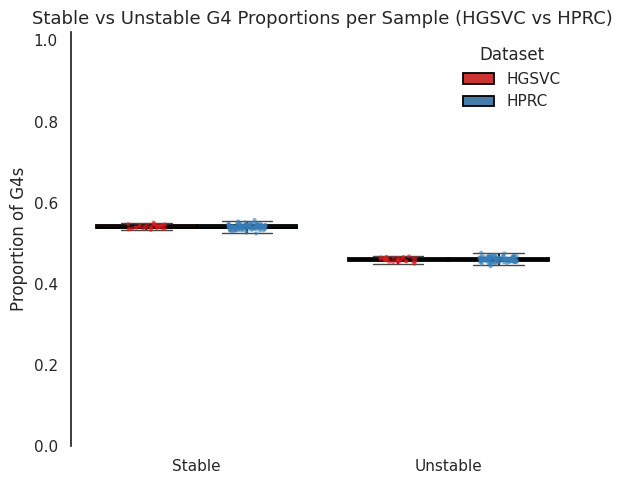

In [36]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# ================== CONFIG ==================
G4_ANNOTATED_CSVS = [
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hgsvc_verkko_annotated.csv",
    "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/all_combined_quadron_results_chrY_hprc_verkko_annotated.csv",
]
Q_STABLE_THRESHOLD = 19.0     # >19 = Stable
EXCLUDE_COLOR_REGIONS = re.compile(r"^(gray|grey|yellow|blue|teal|red|green)\d*$", re.IGNORECASE)
EXCLUDE_EXACT = {"."}

FIGSIZE = (6, 5)  # a bit wider to fit grouped hues
BOX_FILL_STABLE = "#a6cee3"   # not used now, kept for reference
BOX_FILL_UNSTABLE = "#fb9a99"
# ============================================

def infer_dataset(path: str) -> str:
    """Infer dataset from the *filename* only, case-insensitive."""
    name = Path(str(path)).name.lower()
    if re.search(r'(^|[_\-])hgsvc([_\-]|\.|$)', name):
        return "HGSVC"
    if re.search(r'(^|[_\-])hprc([_\-]|\.|$)', name):
        return "HPRC"
    return "Unknown"

def load_g4(paths, q_thresh):
    frames = []
    for p in paths:
        df = pd.read_csv(p)
        df["Sample"] = df["Sample"].astype(str).str.split("_chr").str[0]
        df["Q"] = pd.to_numeric(df["Q"], errors="coerce")
        df["Region"] = df["Region"].astype(str)
        df["Stability"] = np.where(df["Q"] > q_thresh, "Stable", "Unstable")
        df["Dataset"] = infer_dataset(p)  # <-- add dataset label
        frames.append(df[["Sample", "Region", "Stability", "Dataset"]])
    return pd.concat(frames, ignore_index=True)

def main():
    g4 = load_g4(G4_ANNOTATED_CSVS, Q_STABLE_THRESHOLD)

    # Remove unwanted regions
    g4 = g4[~g4["Region"].str.match(EXCLUDE_COLOR_REGIONS)]
    g4 = g4[~g4["Region"].isin(EXCLUDE_EXACT)]

    # Count stable / unstable per sample **and dataset**
    counts = (g4.groupby(["Sample", "Dataset", "Stability"])
                .size()
                .unstack("Stability", fill_value=0))
    # Ensure both columns exist
    for col in ["Stable", "Unstable"]:
        if col not in counts.columns:
            counts[col] = 0

    counts["Total"] = counts["Stable"] + counts["Unstable"]
    counts = counts[counts["Total"] > 0].copy()
    counts["PropStable"] = counts["Stable"] / counts["Total"]
    counts["PropUnstable"] = counts["Unstable"] / counts["Total"]

    # Long format for plotting
    plot_df = (counts[["PropStable", "PropUnstable"]]
               .reset_index()
               .melt(id_vars=["Sample", "Dataset"], var_name="Type", value_name="Proportion"))
    plot_df["Type"] = plot_df["Type"].replace({"PropStable": "Stable", "PropUnstable": "Unstable"})
    plot_df["Type"] = pd.Categorical(plot_df["Type"], categories=["Stable", "Unstable"], ordered=True)

    # Hue order / palette sized to what's present to avoid warnings
    datasets_present = list(pd.unique(plot_df["Dataset"]))
    if set(datasets_present) >= {"HGSVC", "HPRC"}:
        hue_order = ["HGSVC", "HPRC"]
    else:
        hue_order = datasets_present
    dataset_palette = sns.color_palette("Set1", n_colors=len(hue_order))

    # ==== PLOT ====
    sns.set_theme(style="white")
    plt.figure(figsize=FIGSIZE)

    ax = sns.boxplot(
        data=plot_df, x="Type", y="Proportion",
        hue="Dataset", hue_order=hue_order, palette=dataset_palette,
        showcaps=True, showfliers=False, dodge=True,
        boxprops={"edgecolor": "black", "linewidth": 1.3},
        whiskerprops={"linewidth": 1.3, "color": "black"},
        medianprops={"linewidth": 2.0, "color": "black"}
    )

    sns.stripplot(
        data=plot_df, x="Type", y="Proportion",
        hue="Dataset", hue_order=hue_order, palette=dataset_palette,
        alpha=0.6, jitter=0.15, dodge=True, size=3
    )

    # Deduplicate legend (because of box+strip)
    handles, labels = ax.get_legend_handles_labels()
    seen = {}
    u_handles, u_labels = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen[l] = True
            u_handles.append(h)
            u_labels.append(l)
    ax.legend(u_handles, u_labels, title="Dataset", frameon=False, loc="upper right")

    # Clean look
    ax.grid(False)
    ax.set_ylim(0, 1.02)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion of G4s", fontsize=12)
    ax.set_title("Stable vs Unstable G4 Proportions per Sample (HGSVC vs HPRC)", fontsize=13)
    sns.despine(left=False, bottom=True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [6]:
import pandas as pd

# ===== CONFIG =====
region_len_csv = "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/chrY_region_lengths_hprc_filtered.csv"
nonb_summary_csv = "/home/alextu/scratch/arang_rhie_hprc_hgsvc_curated_chrY/curated_chrY_hprc_verkko_nBMST_annotations_collapsed_summary.csv"
# ==================

# Load region lengths
region_df = pd.read_csv(region_len_csv)
tel_len_df = region_df[region_df["Region"] == "TEL"][["Sample", "RegionLengthBP"]].rename(
    columns={"RegionLengthBP": "TEL_SizeBP"}
)

# Load motif-region summary and get DR base coverage in TEL
summary_df = pd.read_csv(nonb_summary_csv)
dr_tel_df = summary_df[(summary_df["Motif"] == "DR") & (summary_df["Region"] == "TEL")][
    ["Sample", "TotalBaseCoverageBP"]
].rename(columns={"TotalBaseCoverageBP": "DR_TEL_BaseCoverageBP"})

# Merge
merged = tel_len_df.merge(dr_tel_df, on="Sample", how="left").fillna(0)

# Optional proportion
merged["Proportion_TEL_DR"] = merged["DR_TEL_BaseCoverageBP"] / merged["TEL_SizeBP"]

# Print
print(merged.sort_values("Proportion_TEL_DR", ascending=False).to_string(index=False))

 Sample  TEL_SizeBP  DR_TEL_BaseCoverageBP  Proportion_TEL_DR
HG03225       13556                  13555           0.999926
HG01943       23383                  23381           0.999914
HG04157       10679                  10678           0.999906
HG01252       14219                  14217           0.999859
HG03050       21217                  21214           0.999859
HG03654       21647                  21641           0.999723
NA18983        8697                   8694           0.999655
HG02647       17970                  17963           0.999610
HG04160       16939                  16932           0.999587
HG04228       15743                  15736           0.999555
HG00642       17838                  17830           0.999552
HG01109       14200                  14193           0.999507
HG03130       13486                  13479           0.999481
HG00140       17021                  17012           0.999471
HG02083       22441                  22429           0.999465
HG00329 